In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(binom)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


# Lineage assignment (Mez2 vs A00 vs chimp)

In [2]:
mh <- "a00"

In [3]:
highcov_all %<-% { read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, tv_only = FALSE) %>%
    select(chrom, pos, REF, ALT, mez2, chimp, !!mh) %>%
    filter(complete.cases(.)) }

In [4]:
highcov_tv %<-% { read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, tv_only = TRUE) %>%
    select(chrom, pos, REF, ALT, mez2, chimp, !!mh) %>%
    filter(complete.cases(.)) }

In [5]:
calculate_proportions <- function(highcov) {
    props <- future_map_dfr(c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2"), function(test) {
        capture <- ifelse(test == "elsidron2", "lippold", "full")

        test_df <- read_vcf(here(paste0("data/vcf/", capture, "_", test, ".vcf.gz")), mindp = 3, maxdp = 0.98)
        joined <- inner_join(highcov, test_df, by = c("chrom", "pos", "REF")) %>% filter(ALT.y == "" | ALT.x == ALT.y)

        joined <- filter(joined, complete.cases(joined))

        tibble(
            hum    = sum(joined[["mez2"]] == joined[["chimp"]] & joined[[mh]] != joined[["mez2"]]  & joined[[test]] == joined[[mh]]),
            neand  = sum(joined[[mh]]  == joined[["chimp"]] & joined[[mh]] != joined[["mez2"]]  & joined[[test]] == joined[["mez2"]]),
            ancestral = sum(joined[["mez2"]] == joined[[mh]]   & joined[[mh]] != joined[["chimp"]] & joined[[test]] == joined[["chimp"]]),
            total  = hum + neand + ancestral
        ) %>%
            gather(lineage, count, -total) %>%
            mutate(
                name = test,
                map2(count, total, ~ binom.confint(.x, .y, methods = "exact") %>%
                                         select(mean, lower, upper))) %>%
            unnest %>%
            select(name, everything())
    })
    props
}

In [6]:
props_all <- calculate_proportions(highcov_all)
props_tv <- calculate_proportions(highcov_tv)

Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”Warning message:
“`cols` is now required.
Please use `cols = c(`map2(...)`)`”

Both Denisovan Y chromosomes fall with close to 100% certainty to a branch ancestral to AMH and Neanderthals.

The small number of sites falling on human or Neanderthal branches is easily explained by DNA damage - a truly ancestral site carrying a damage substitution will flip with 50% probability to one or the other, which is what we see for both Denisova 4 and Denisova 8.

In [7]:
plot_lineages <- function(df, archaic) {
    par(mar = c(1, 1, 1, 1))

    stopifnot(archaic %in% df$name)

    name <- case_when(
        archaic == "den8" ~ "Denisova 8",
        archaic == "den4" ~ "Denisova 4",
        archaic == "spy1" ~ "Spy 1",
        archaic == "mez2" ~ "Mezmaiskaya 2",
        archaic == "elsidron2" ~ "El Sidrón 1253",
        archaic == "shotgun_spy1" ~ "Spy 1 (shotgun)",
        archaic == "shotgun_mez2" ~ "Mazmaiskaya 2 (shotgun)"
    )

    ancestral <- filter(df, name == archaic, lineage == "ancestral")[, c("mean", "lower", "upper")] * 100
    hum <- filter(df, name == archaic, lineage == "hum")[, c("mean", "lower", "upper")] * 100
    neand <- filter(df, name == archaic, lineage == "neand")[, c("mean", "lower", "upper")] * 100

    count_ancestral <- filter(df, name == archaic, lineage == "ancestral")$count
    count_hum <- filter(df, name == archaic, lineage == "hum")$count
    count_neand <- filter(df, name == archaic, lineage == "neand")$count

    total <- filter(df, name == archaic)$total[1]

    plot(0, main = name, axes = FALSE, xaxs="i", yaxs="i", type = "n", xlab = "", ylab = "", xlim = c(0, 10), ylim = c(0, 10))

    if (ancestral[1] > hum[1] & ancestral[1] > neand[1]) {
        rect(9.4, 7.5, 5.4, 6, border = "darkgreen")
        w <- list(ancestral = 7, hum = 1, neand = 1)
        a <- list(ancestral = 1, hum = 0.25, neand = 0.25)
        segments(x0 = 8.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkred", lend = "round", lwd = w$hum)
        segments(x0 = 1.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkblue", lend = "round", lwd = w$neand)
        segments(x0 = 5, x1 = 5, y0 = 4, y1 = 8.5, col = "darkgreen", lend = "round", lwd = w$anc)
    } else {
        rect(4, 3.8, 0.01, 5.3, border = "darkblue")
        w <- list(anc = 1, hum = 1, neand = 7)
        a <- list(anc = 0.25, hum = 0.25, neand = 1)
        segments(x0 = 8.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkred", lend = "round", lwd = w$hum)
        segments(x0 = 5, x1 = 5, y0 = 4, y1 = 8.5, col = "darkgreen", lend = "round", lwd = w$anc)
        segments(x0 = 1.5, x1 = 5, y0 = 1.5, y1 = 4, col = "darkblue", lend = "round", lwd = w$neand)
    }

    text(5, 9.5, "\nancestral", col = "darkgreen")
    text(7.4, 6.8, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", ancestral[1], ancestral[2], ancestral[3], count_ancestral, total),
         col = alpha("darkgreen", a$anc))

    text(1.5, 0.8, "Mezmaiskaya 2", col = "darkblue")
    text(2, 4.5, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", neand[1], neand[2], neand[3], count_neand, total),
         col = alpha("darkblue", a$neand))

    text(8.5, 0.8, "A00", col = "darkred")
    text(7.8, 4.5, sprintf("%.1f%% [%.1f - %.1f]\n%d out of %d sites", hum[1], hum[2], hum[3], count_hum, total),
         col = alpha("darkred", a$hum))

}

## All SNPs

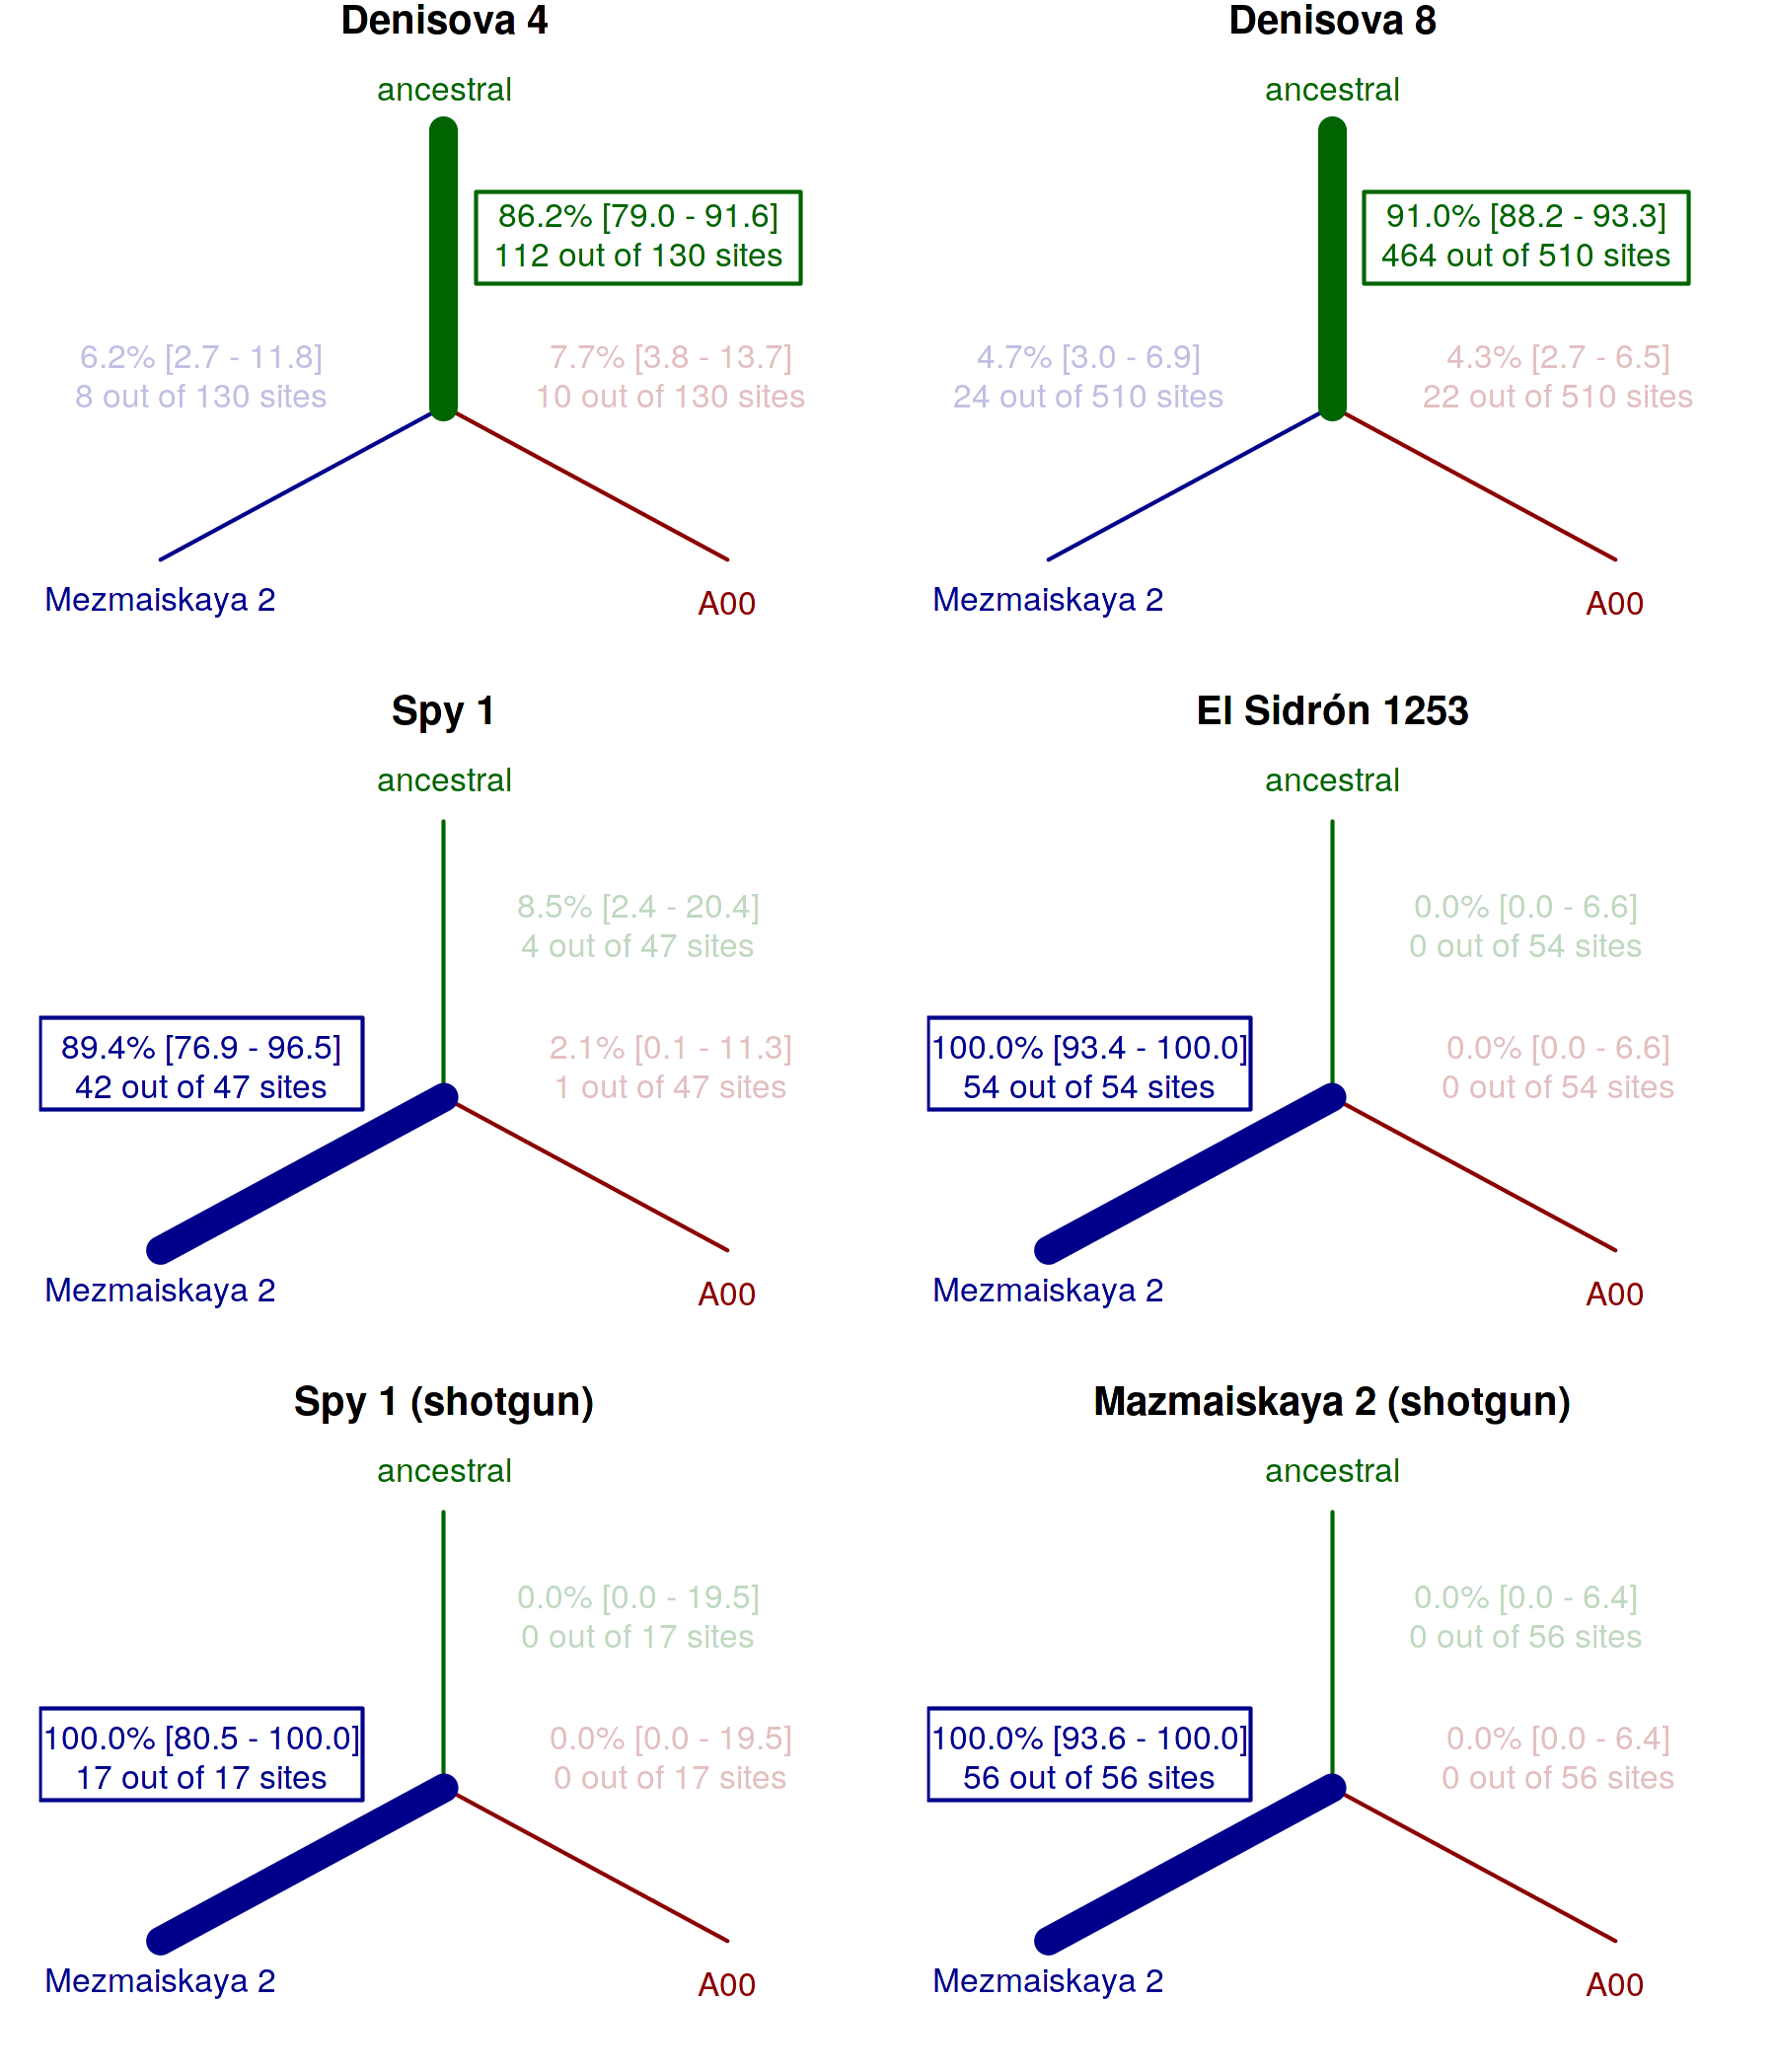

In [8]:
set_dim(6, 7)

par(mfrow = c(3, 2))

for (arch in c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2")) {
    plot_lineages(props_all, arch)
}

## Excluding potential damage

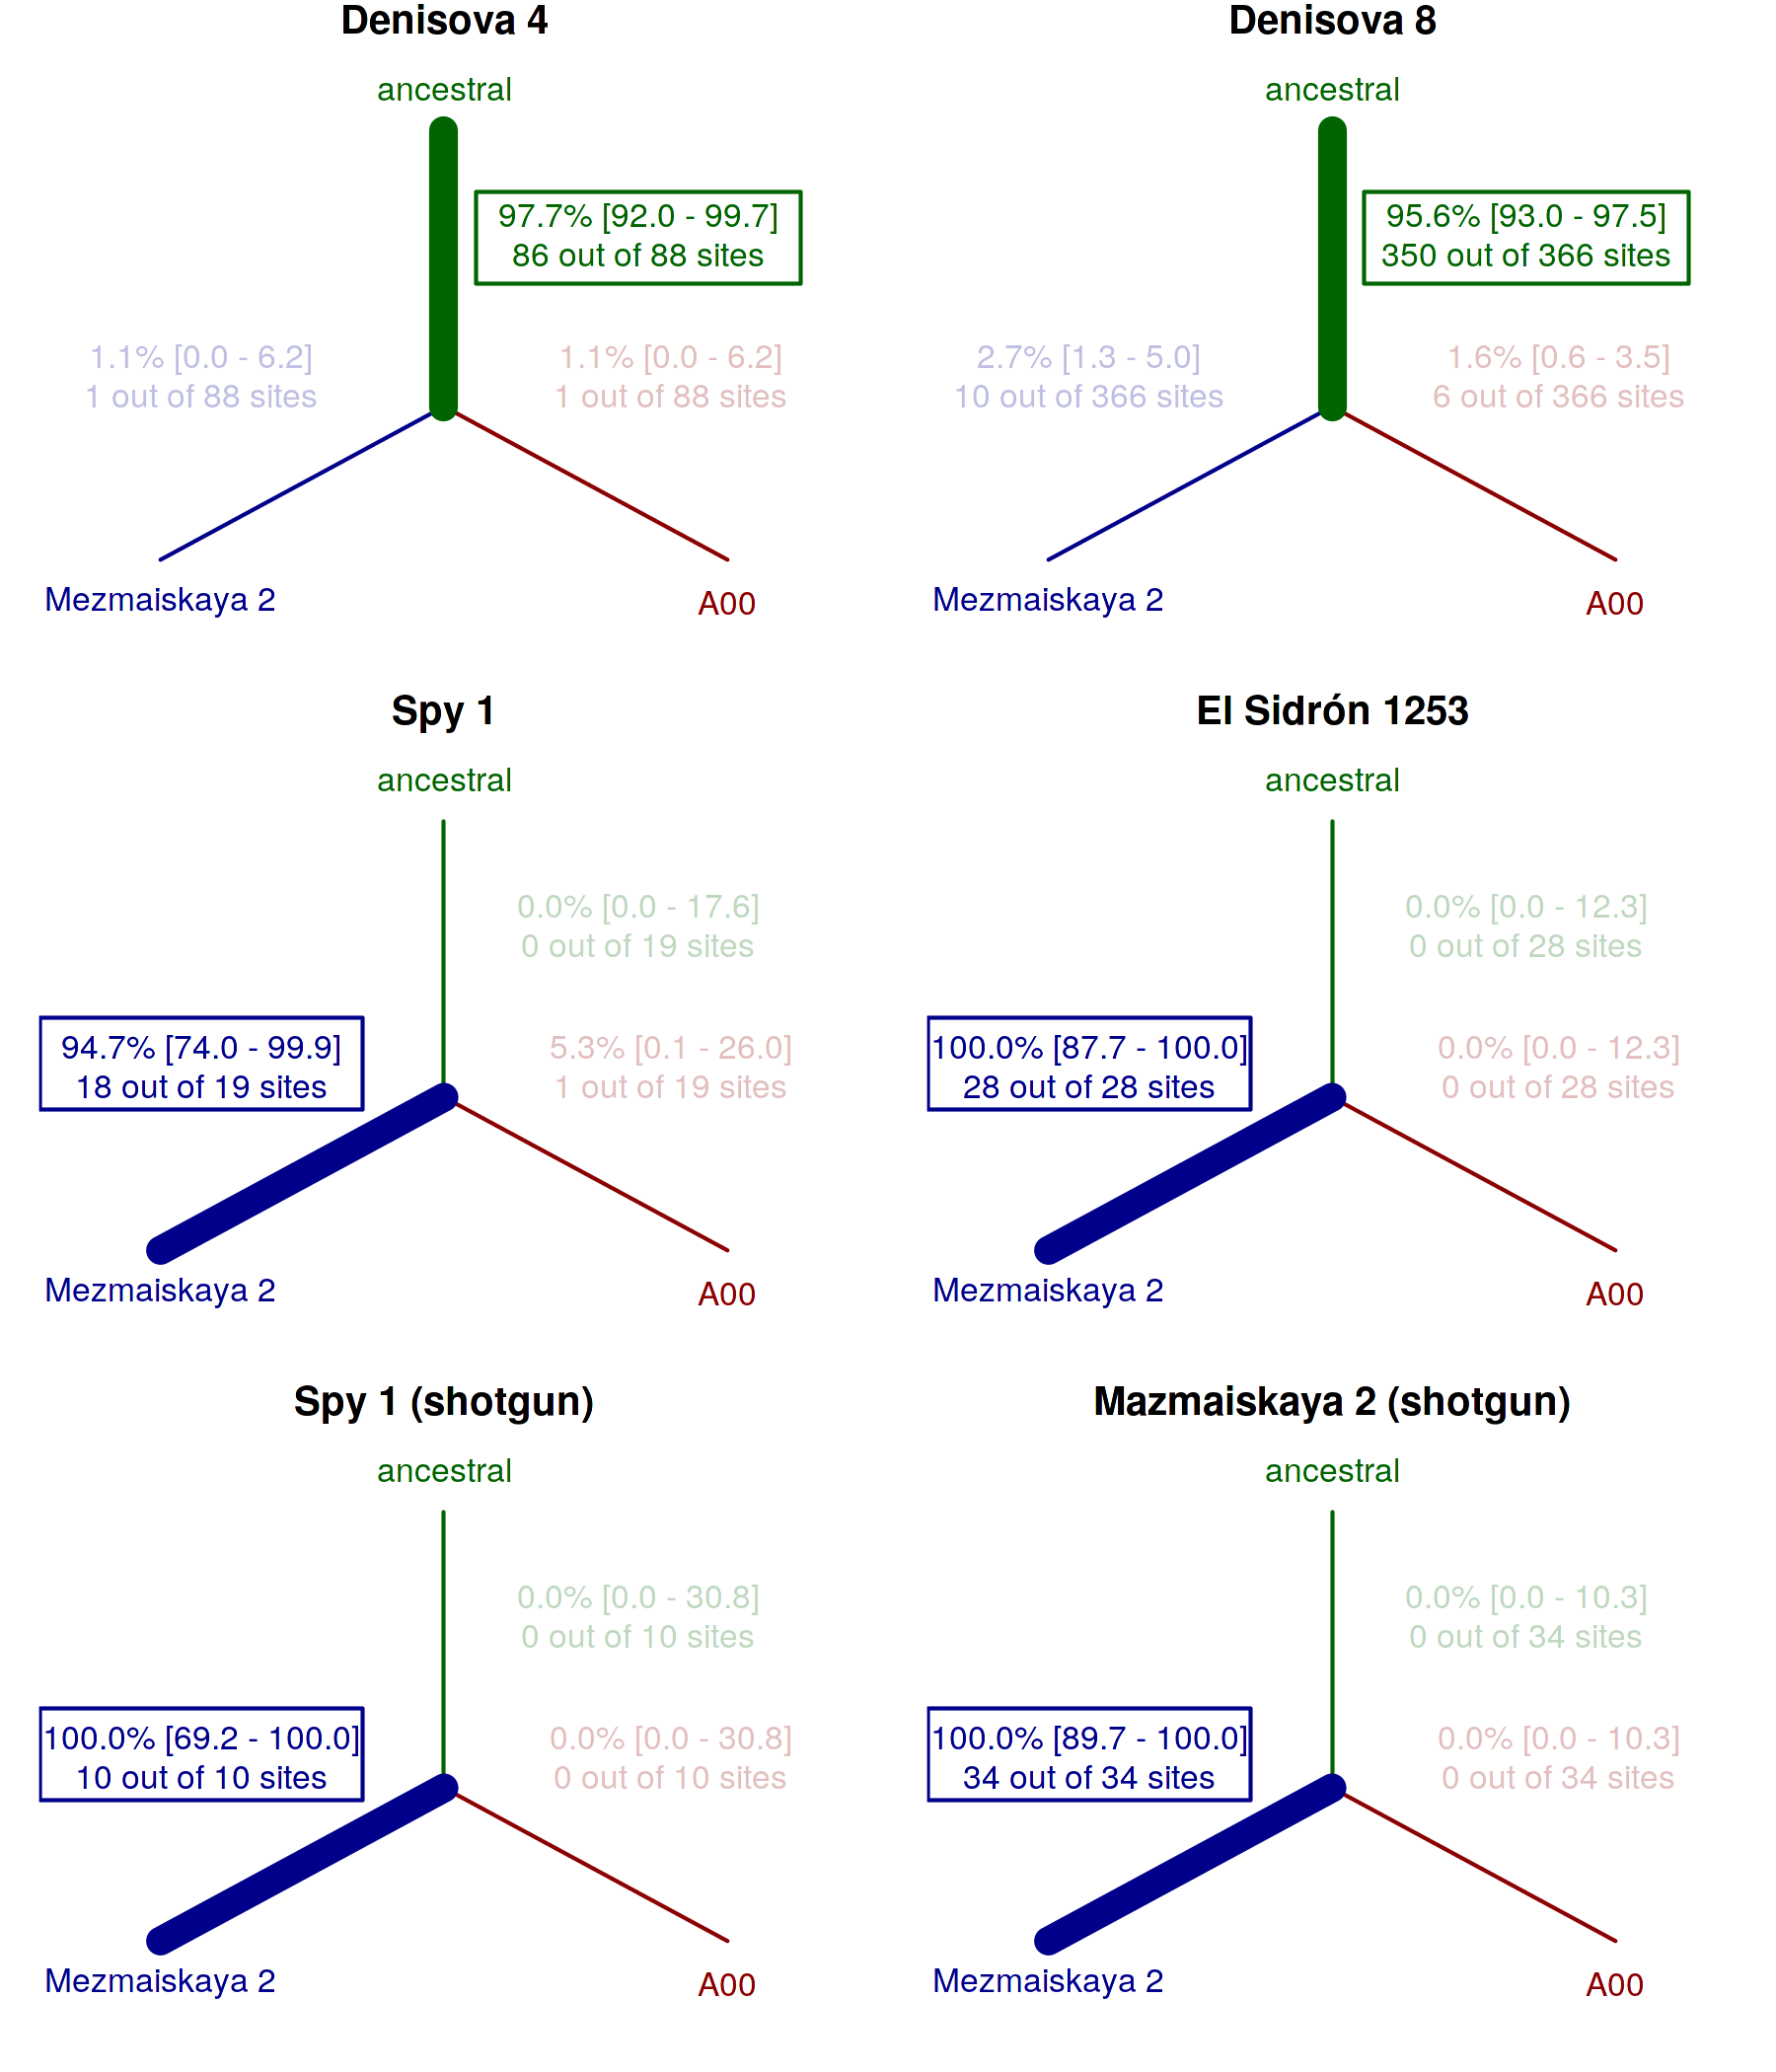

In [9]:
set_dim(6, 7)

par(mfrow = c(3, 2))

for (arch in c("den4", "den8", "spy1", "elsidron2", "shotgun_spy1", "shotgun_mez2")) {
    plot_lineages(props_tv, arch)
}